In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


<h1>Background</h1>

Image classification is one of the most fundamental problems in computer vision. It focuses on teaching machines to identify the object or category that appears in an image.

Visual recognition plays a crucial role in many advanced technologies. For example, autonomous driving relies heavily on a vehicle’s ability to accurately classify road signs, pedestrians, vehicles, and other objects in real time. Medical imaging systems use classification to detect abnormalities such as tumors or fractures. Security applications depend on visual recognition for facial identification, object detection, and monitoring. In nearly every area where computers interact with the physical world, image classification forms the first step that enables high-level reasoning and decision making.

To gain hands-on experience with this essential concept, I chose to experiment with a classic and widely used dataset: the Dogs vs. Cats image dataset.

<h3>Data</h3>
Will Cukierski. Dogs vs. Cats Redux: Kernels Edition. https://kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition, 2016. Kaggle.

<h3>EDA</h3>
During the EDA, I inspected the raw images and found that their sizes are varied and are not consistently square. But their ratio difference is not huge. I resized all images to a uniform 150×150.
I applied a series of augmentation techniques, including Random Horizontal Flip, Random Rotation, Color Jitter, and Random Affine transformations. These augmentations help the model become more robust.

<h3>Model</h3>
I evaluated three different convolutional neural network architectures to compare performance: BaselineCNN, ResNet18, and EfficientNet-B0.

First one is a lightweight, 3-convolution-layer Baseline CNN model designed to provide a simple benchmark.

ResNet18 is the second; it uses residual blocks with skip connections.

EfficientNet-B0 is the final modern CNN that scales depth, width, and image resolution in a balanced way using a compound scaling method. It typically provides high accuracy while maintaining computational efficiency. With Fewer parameters, it is more efficient than ResNet18.

<h3>Optimization and Results</h3>
I have fine-tuned the learning rate, decay, and epochs to optimize the model architecture.

Overall, the EfficientNet-B0 achieves the best result.

<h3>Conclusion</h3>
In this project, I explored image classification on the classic Dogs vs Cats dataset using three deep learning models: a custom CNN, ResNet18, and EfficientNet-B0. Through careful EDA, data preprocessing, augmentation, and hyperparameter tuning, all models achieved reasonable performance. Among them, EfficientNet-B0 achieved the best results, and my best submission reached a log loss of 0.07456. It confirms that transfer learning with pretrained models, combined with proper data preparation can significantly improve performance on visual recognition tasks.


<h1>Data Loading</h1>

The training dataset contains 25,000 colorful images, while the test dataset contains 12,500 images, each named according to a numeric ID. In the training set, each image has an associated label indicating its category (dog or cat) stored as int64. Images were previewed to confirm that they are realistic photographs with varied width, height, and brightness.




In [3]:
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import random

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18

from sklearn.model_selection import train_test_split

from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip","r") as z:
    z.extractall(".")

print('unzip finished')

unzip finished


In [5]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1) # 1 = Dog
    else:
        categories.append(0) # 0 = Cat

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


print(df.head())

        filename  category
0   dog.9502.jpg         1
1  cat.11650.jpg         0
2   cat.1680.jpg         0
3   dog.4658.jpg         1
4  cat.11031.jpg         0


In [6]:
print(df.shape)

(25000, 2)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   category  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [8]:
test_dir = "./test"

# Count all files in the test folder
num_test_images = len(os.listdir(test_dir))

print(f"Number of images in test folder: {num_test_images}")

Number of images in test folder: 12500


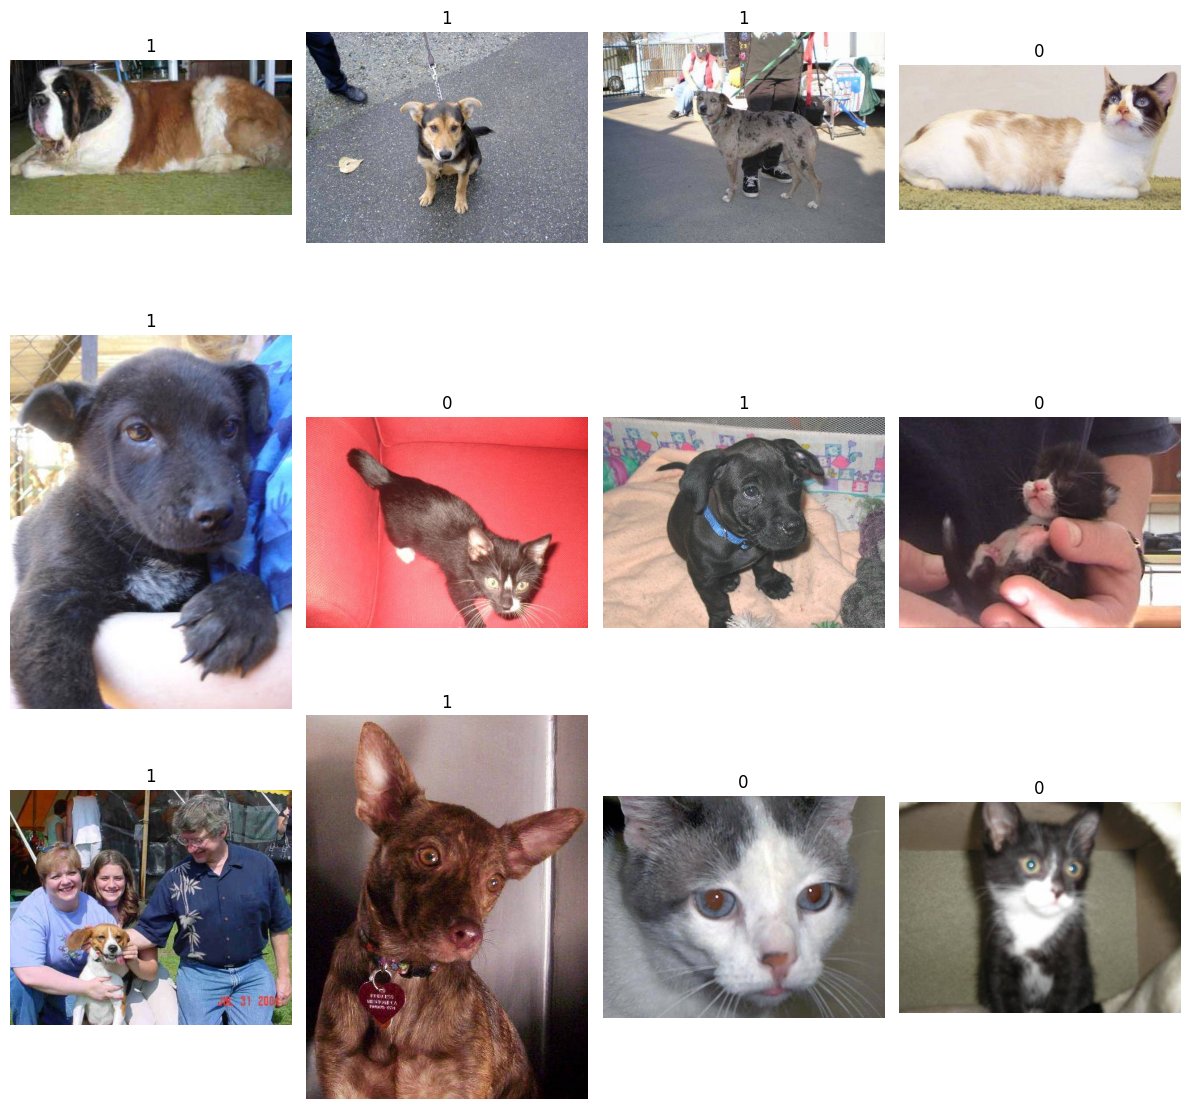

In [9]:
#Visualize the sample random photos
plt.figure(figsize=(12, 12))

for i in range(12):
    file = random.choice(df['filename'].values)
    label = df[df.filename == file].category.values[0]

    img = Image.open(os.path.join("./train", file))

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()


<h1>Exploratory Data Analysis (EDA)</h1>

To better understand the dataset, diagrams were created to visualize the distributions of image width, height, and brightness, confirming that the images are realistic photographs with varied sizes and brightness conditions.


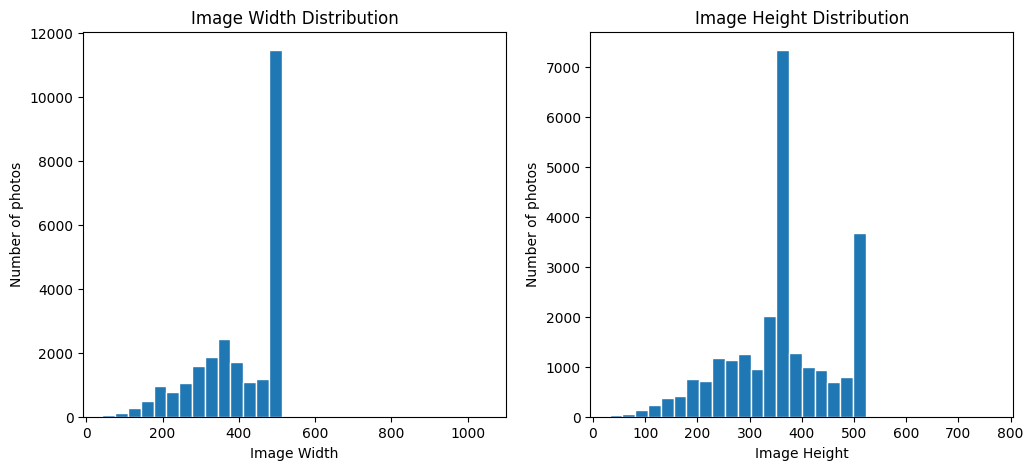

In [10]:
widths = []
heights = []

for file in df['filename']:
    img = Image.open(os.path.join("./train", file))
    w, h = img.size
    widths.append(w)
    heights.append(h)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(widths, bins=30, edgecolor = 'white')
plt.title("Image Width Distribution")
plt.xlabel("Image Width")
plt.ylabel("Number of photos")

plt.subplot(1,2,2)
plt.hist(heights, bins=30, edgecolor = 'white')
plt.title("Image Height Distribution")
plt.xlabel("Image Height")
plt.ylabel("Number of photos")

plt.show()

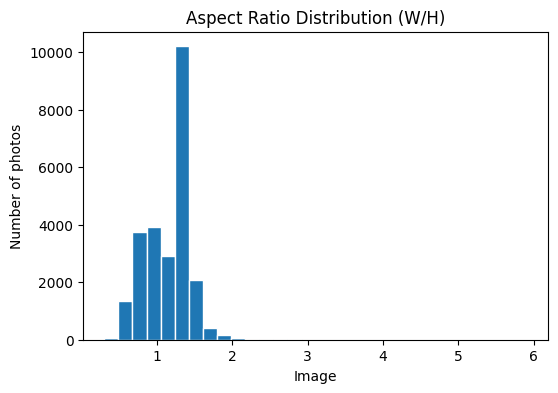

In [11]:
aspect_ratios = [w/h for w, h in zip(widths, heights)]

plt.figure(figsize=(6,4))
plt.hist(aspect_ratios, bins=30, edgecolor = 'white')
plt.title("Aspect Ratio Distribution (W/H)")
plt.xlabel("Image")
plt.ylabel("Number of photos")
plt.show()

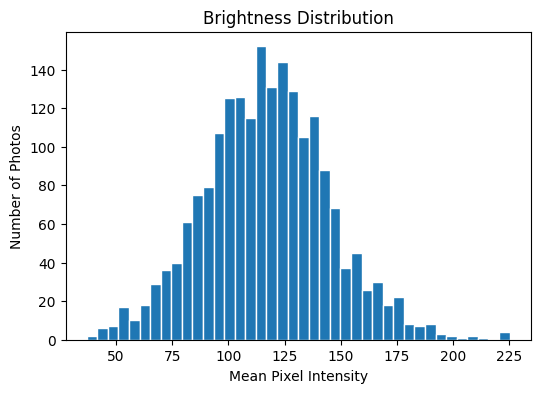

In [12]:
brightness = []

for file in df['filename'][:2000]:  # sample to save time
    img = Image.open(os.path.join("./train", file)).convert("L")
    brightness.append(np.mean(img))

plt.figure(figsize=(6,4))
plt.hist(brightness, bins=40, edgecolor = 'white')
plt.title("Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Photos")
plt.show()

<h2>Data Augmentation</h2>

To prepare the images for deep learning models, we applied the following steps:

Resizing: All images were resized to 150×150 pixels to standardize input dimensions.

Normalization: Pixel values were scaled to the range 0 to 1 to help with faster convergence.

Data Augmentation: To improve generalization and reduce overfitting, we applied random transformations, including horizontal flips, rotations, color jitter, and affine transformations.

Consistency: The same resizing and normalization were applied to the validation and test datasets to ensure consistent input distribution for evaluation.

In [13]:
class CatsDogsDataset(Dataset):
    def __init__(self, df, directory, transform=None):
        self.df = df.reset_index(drop=True)
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.loc[idx, "filename"]
        label = self.df.loc[idx, "category"]

        img_path = os.path.join(self.directory, filename)
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [14]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
        transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),                  # converts to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


In [15]:
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

train_dataset = CatsDogsDataset(
    df=train_df,
    directory="./train",
    transform=train_transform
)

val_dataset = CatsDogsDataset(
    df=val_df,
    directory="./train",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
images, labels = next(iter(train_loader))
print(images.shape, labels[:10])

torch.Size([32, 3, 150, 150]) tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0])


This is after data augmentation and undo normalization, we can check the dataset for the actual training.

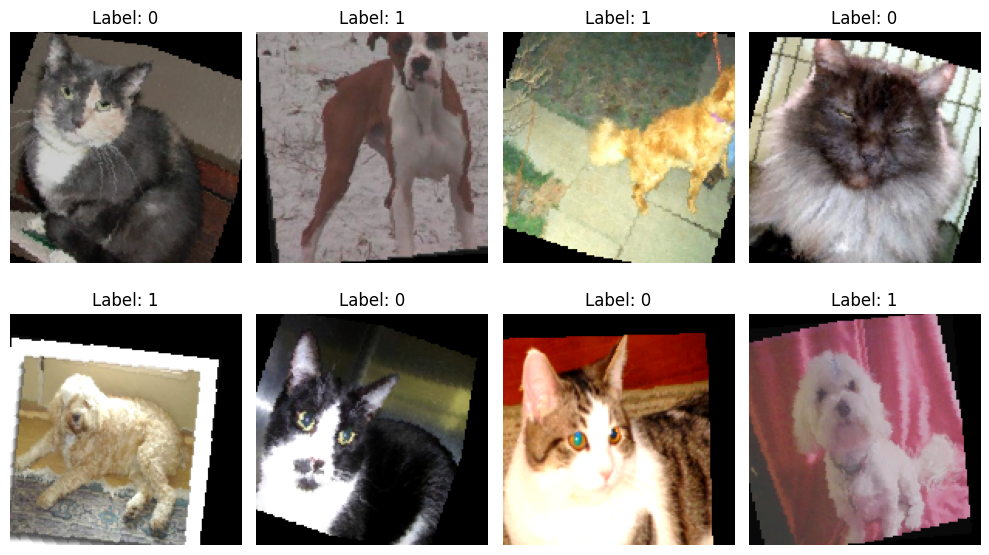

In [22]:
num_images = 8
fig, axes = plt.subplots(2, 4, figsize=(10, 6))

for i in range(num_images):
    img, label = train_dataset[i]  # transformed image
    
    # undo normalization for display
    img_disp = img.clone()
    img_disp = img_disp * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_disp = img_disp + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img_disp = img_disp.clamp(0,1)
    
    ax = axes[i//4, i%4]
    ax.imshow(img_disp.permute(1, 2, 0))
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

<h1>Model Architecture</h1>
The three models—BaselineCNN, ResNet18, and EfficientNet-B0 were used in the project. 

<h2>Evaluation Metric</h2>
The models were evaluated in alignment with the competition’s submission requirements, using log loss as the primary metric. Log loss measures the accuracy of predicted probabilities for binary classification. A smaller log loss indicates better predictive performance.

<h2>Baseline CNN</h2>
The BaselineCNN is a simple convolutional neural network designed for binary image classification (dogs vs cats). It consists of three convolutional layers with increasing filter sizes, each followed by ReLU activations and max pooling to extract features and reduce feature map size. The convolutional output is flattened and passed through a fully connected layer with 128 units, followed by ReLU and dropout,0.3, for regularization. Finally, a single output with sigmoid activation predicts the probability of the image being a dog.

In [18]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 18 * 18, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [19]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total


In [20]:
from sklearn.metrics import log_loss

def evaluate_log_loss(model, loader, device):
    """
    Compute log loss (binary cross-entropy) on a dataset.
    Returns a single float.
    """
    model.eval()
    preds = []
    true_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.cpu().numpy()

            # Forward pass
            logits = model(images).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy()  # convert logits -> probabilities

            preds.extend(probs)
            true_labels.extend(labels)

    # compute log loss
    return log_loss(true_labels, preds, eps=1e-7)


In [21]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=5, max_steps=None):
    model.to(device)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    global_step = 0

    for epoch in range(epochs):
        model.train()
        total, correct, train_loss_epoch = 0, 0, 0

        for images, labels in train_loader:
            if max_steps is not None and global_step >= max_steps:
                print(f"Reached max_steps={max_steps}")
                return history, evaluate_log_loss(model, val_loader, device)

            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            logits = model(images).squeeze(1)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item() * images.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            global_step += 1

        train_loss_epoch /= total
        train_acc_epoch = correct / total

        # validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        history["train_loss"].append(train_loss_epoch)
        history["train_acc"].append(train_acc_epoch)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Final log loss
    val_logloss = evaluate_log_loss(model, val_loader, device)
    return history, val_logloss


In [20]:
def plot_training_curves(history, model_name="Model"):

    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14,5))

    # ------- LOSS -------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} — Loss Curve")
    plt.legend()
    plt.grid(True)

    # ------- ACCURACY -------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label='Train Acc')
    plt.plot(epochs, history["val_acc"], label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} — Accuracy Curve")
    plt.legend()
    plt.grid(True)

    plt.show()



In [21]:
cnn_model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

cnn_history, cnn_logloss = train_and_evaluate(
    cnn_model, train_loader, val_loader, criterion, optimizer, device, epochs=5
)


Epoch 1/5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5010
Epoch 2/5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5010
Epoch 3/5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5010
Epoch 4/5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5010
Epoch 5/5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5010


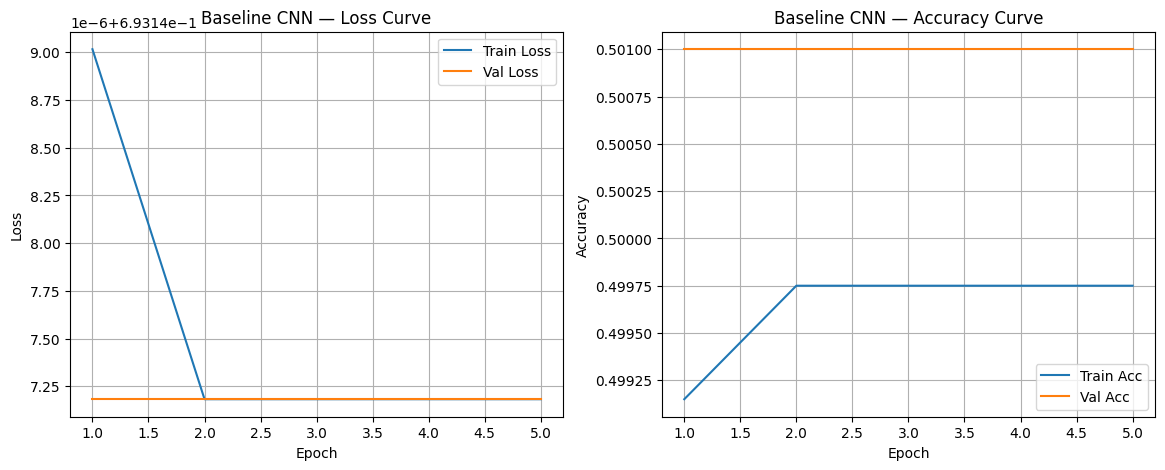

In [22]:
plot_training_curves(cnn_history, model_name="Baseline CNN")

<h2>ResNet18</h2>
ResNet18 is a deep residual network designed to address the vanishing gradient problem using residual connections that allow gradients to flow directly through skip connections. The network consists of 18 convolutional layers.

Using this pretrained model allows us to leverage transfer learning, which significantly improves the performance compared to training a CNN from scratch.

During initial training, the model was optimized with Adam and a learning rate of 1e-4, and performance was evaluated using binary cross-entropy and log loss.

In [23]:
resnet_model = resnet18(weights="IMAGENET1K_V1")
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 1)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)

resnet_history, resnet_logloss = train_and_evaluate(
    resnet_model, train_loader, val_loader, criterion, optimizer, device, epochs=5
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


Epoch 1/5 | Train Loss: 0.1322 | Val Loss: 0.0612 | Val Acc: 0.9770
Epoch 2/5 | Train Loss: 0.0839 | Val Loss: 0.0691 | Val Acc: 0.9750
Epoch 3/5 | Train Loss: 0.0673 | Val Loss: 0.0650 | Val Acc: 0.9768
Epoch 4/5 | Train Loss: 0.0572 | Val Loss: 0.0643 | Val Acc: 0.9758
Epoch 5/5 | Train Loss: 0.0519 | Val Loss: 0.0886 | Val Acc: 0.9670


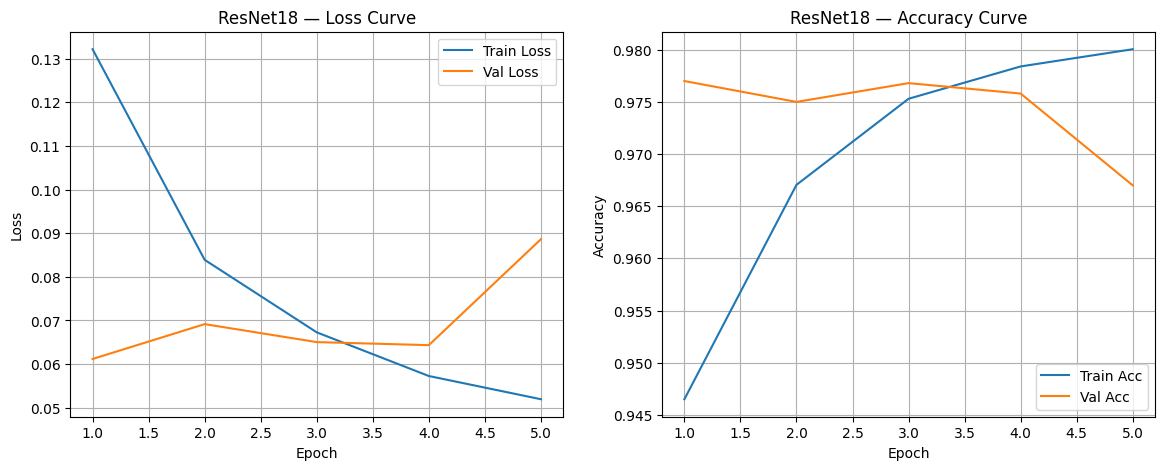

In [24]:
plot_training_curves(resnet_history, model_name="ResNet18")

In [25]:
from torchvision.models import efficientnet_b0

eff_model = efficientnet_b0(weights="IMAGENET1K_V1")
eff_model.classifier[1] = nn.Linear(eff_model.classifier[1].in_features, 1)
optimizer = torch.optim.Adam(eff_model.parameters(), lr=1e-4)

eff_history, eff_logloss = train_and_evaluate(
    eff_model, train_loader, val_loader, criterion, optimizer, device, epochs=5
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 186MB/s]


Epoch 1/5 | Train Loss: 0.1591 | Val Loss: 0.0537 | Val Acc: 0.9808
Epoch 2/5 | Train Loss: 0.0744 | Val Loss: 0.0380 | Val Acc: 0.9868
Epoch 3/5 | Train Loss: 0.0578 | Val Loss: 0.0370 | Val Acc: 0.9862
Epoch 4/5 | Train Loss: 0.0460 | Val Loss: 0.0376 | Val Acc: 0.9856
Epoch 5/5 | Train Loss: 0.0377 | Val Loss: 0.0407 | Val Acc: 0.9856


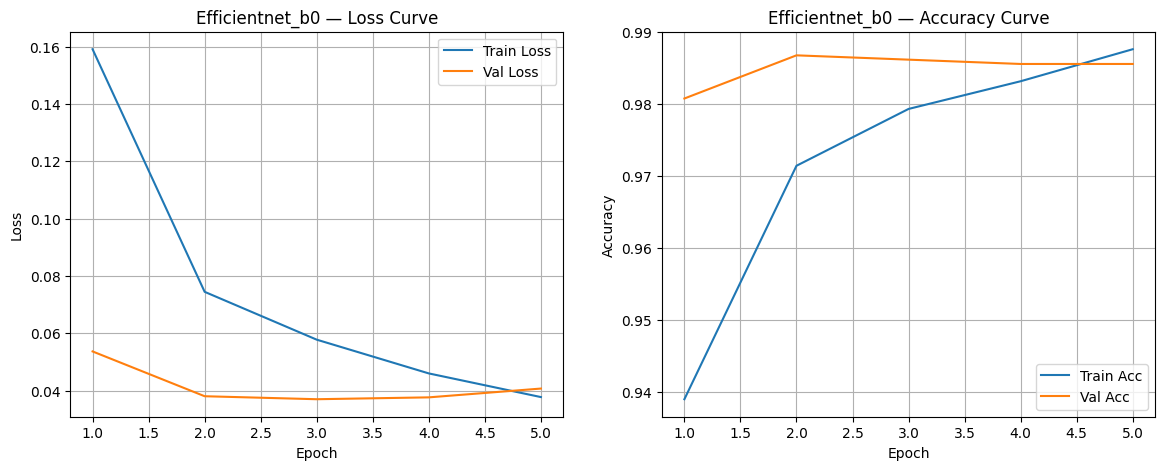

In [26]:
plot_training_curves(eff_history, model_name="Efficientnet_b0")

<h1>Optimization and Results</h1>

Results from the initial model training.

The Baseline CNN performed poorly, with log loss close to 0.693. 

ResNet18, achieved significantly better performance, 0.095854. 

EfficientNet-B0, performs best among the three, log loss is 0.036868.

In [27]:
results = pd.DataFrame({
    "Model": ["CNN", "ResNet18", "EfficientNet-B0"],
    "LogLoss": [cnn_logloss, resnet_logloss, eff_logloss]
})

print(results)

             Model   LogLoss
0              CNN  0.693147
1         ResNet18  0.089044
2  EfficientNet-B0  0.040902


<h2>Optimization</h2>

To improve model performance, I have applied several optimization strategies.

Different learning rates (e.g., 1e-3, 1e-4, 5e-5, 1e-5) were tested for each model. The ideal learning rate is 5e-05.

Regularization via weight decay (L2 regularization) was applied to prevent overfitting. The best weight decay is 0.0001

Max step is used because previous training with the entire test dataset is time-consuming. So reduce the computational cost with a max step restriction.


In [28]:
import itertools
from copy import deepcopy

def create_model(model_name):
    if model_name == "baseline":
        return BaselineCNN()
    
    elif model_name == "resnet18":
        m = models.resnet18(weights="IMAGENET1K_V1")
        m.fc = nn.Linear(m.fc.in_features, 1)
        return m
        
    elif model_name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="IMAGENET1K_V1")
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, 1)
        return m

    else:
        raise ValueError(f"Unknown model name: {model_name}")


model_list = ["baseline", "resnet18", "efficientnet_b0"]


param_grid = {
    "learning_rate": [1e-3, 5e-4, 5e-5],
    "weight_decay": [0.0, 1e-4],
    "epochs": [5],
    "max_steps": [300]  # <-- speeds up training!
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


<h3>Result</h3>
Although various optimization strategies were applied to improve model performance. If we checked the logloss result. The best result is from efficientnet_b0,learning_rate: 0.001, weight_decay: 0.0, epochs: 5. The logloss is 0.0684, less than the 0.036868. But the reason is probably that I set up the max step to 300. I tested with the entire training set later. The final result improves but not a lot.

In [29]:
results = []

for model_name in model_list:
    for cfg in param_combinations:
        
        print(f"\n===== Model: {model_name} | Config: {cfg} =====")
        
        # fresh model for this experiment
        model = create_model(model_name)
        model.to(device)
        
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=cfg["learning_rate"],
            weight_decay=cfg["weight_decay"]
        )
        
        criterion = nn.BCEWithLogitsLoss()
        
        history, logloss = train_and_evaluate(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            device,
            epochs=cfg["epochs"],
            max_steps=cfg["max_steps"]
        )
        
        results.append({
            "model": model_name,
            "config": cfg,
            "logloss": logloss
        })



===== Model: baseline | Config: {'learning_rate': 0.001, 'weight_decay': 0.0, 'epochs': 5, 'max_steps': 300} =====
Reached max_steps=300

===== Model: baseline | Config: {'learning_rate': 0.001, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300} =====
Reached max_steps=300

===== Model: baseline | Config: {'learning_rate': 0.0005, 'weight_decay': 0.0, 'epochs': 5, 'max_steps': 300} =====
Reached max_steps=300

===== Model: baseline | Config: {'learning_rate': 0.0005, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300} =====
Reached max_steps=300

===== Model: baseline | Config: {'learning_rate': 5e-05, 'weight_decay': 0.0, 'epochs': 5, 'max_steps': 300} =====
Reached max_steps=300

===== Model: baseline | Config: {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300} =====
Reached max_steps=300

===== Model: resnet18 | Config: {'learning_rate': 0.001, 'weight_decay': 0.0, 'epochs': 5, 'max_steps': 300} =====
Reached max_steps=300

===== Model: resnet18 

In [31]:
sorted_results = sorted(results, key=lambda x: x["logloss"])

print("\n===== Final Ranking =====")
for r in sorted_results:
    print(f"LogLoss: {r['model']} | {r['logloss']:.4f} | {r['config']}")



===== Final Ranking =====
LogLoss: efficientnet_b0 | 0.0699 | {'learning_rate': 0.0005, 'weight_decay': 0.0, 'epochs': 5, 'max_steps': 300}
LogLoss: resnet18 | 0.0770 | {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300}
LogLoss: resnet18 | 0.0788 | {'learning_rate': 5e-05, 'weight_decay': 0.0, 'epochs': 5, 'max_steps': 300}
LogLoss: efficientnet_b0 | 0.0799 | {'learning_rate': 0.0005, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300}
LogLoss: efficientnet_b0 | 0.0949 | {'learning_rate': 0.001, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300}
LogLoss: efficientnet_b0 | 0.0992 | {'learning_rate': 0.001, 'weight_decay': 0.0, 'epochs': 5, 'max_steps': 300}
LogLoss: resnet18 | 0.1057 | {'learning_rate': 0.0005, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300}
LogLoss: efficientnet_b0 | 0.1070 | {'learning_rate': 5e-05, 'weight_decay': 0.0001, 'epochs': 5, 'max_steps': 300}
LogLoss: efficientnet_b0 | 0.1072 | {'learning_rate': 5e-05, 'weight_dec

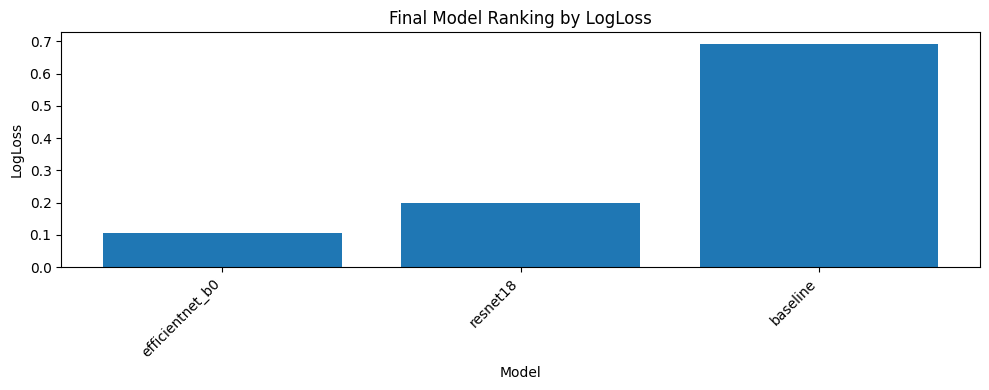

In [38]:
model_names = [r["model"] for r in sorted_results]
logloss_values = [r["logloss"] for r in sorted_results]

plt.figure(figsize=(10, 4))
plt.bar(model_names, logloss_values)
plt.xticks(rotation=45, ha='right')
plt.title("Final Model Ranking by LogLoss")
plt.xlabel("Model")
plt.ylabel("LogLoss")
plt.tight_layout()
plt.show()

In [32]:
import torch.optim as optim
best_eff_model = deepcopy(models.efficientnet_b0(weights="IMAGENET1K_V1"))
best_eff_model.classifier[1] = nn.Linear(best_eff_model.classifier[1].in_features, 1)
best_eff_model.to(device)

# Define optimizer with new learning rate and weight decay
optimizer = optim.Adam(
    best_eff_model.parameters(),
    lr=5e-5,
    weight_decay=0.0001
)

final_history, final_logloss = train_and_evaluate(
    best_eff_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=10   # longer training for final model
)


print("Updated EfficientNet-B0 Validation Log Loss:", final_logloss)

Epoch 1/10 | Train Loss: 0.2045 | Val Loss: 0.0588 | Val Acc: 0.9814
Epoch 2/10 | Train Loss: 0.0908 | Val Loss: 0.0562 | Val Acc: 0.9772
Epoch 3/10 | Train Loss: 0.0671 | Val Loss: 0.0398 | Val Acc: 0.9848
Epoch 4/10 | Train Loss: 0.0569 | Val Loss: 0.0414 | Val Acc: 0.9842
Epoch 5/10 | Train Loss: 0.0474 | Val Loss: 0.0351 | Val Acc: 0.9870
Epoch 6/10 | Train Loss: 0.0376 | Val Loss: 0.0313 | Val Acc: 0.9884
Epoch 7/10 | Train Loss: 0.0336 | Val Loss: 0.0294 | Val Acc: 0.9900
Epoch 8/10 | Train Loss: 0.0306 | Val Loss: 0.0307 | Val Acc: 0.9906
Epoch 9/10 | Train Loss: 0.0258 | Val Loss: 0.0317 | Val Acc: 0.9884
Epoch 10/10 | Train Loss: 0.0213 | Val Loss: 0.0349 | Val Acc: 0.9880
Updated EfficientNet-B0 Validation Log Loss: 0.035041287004313


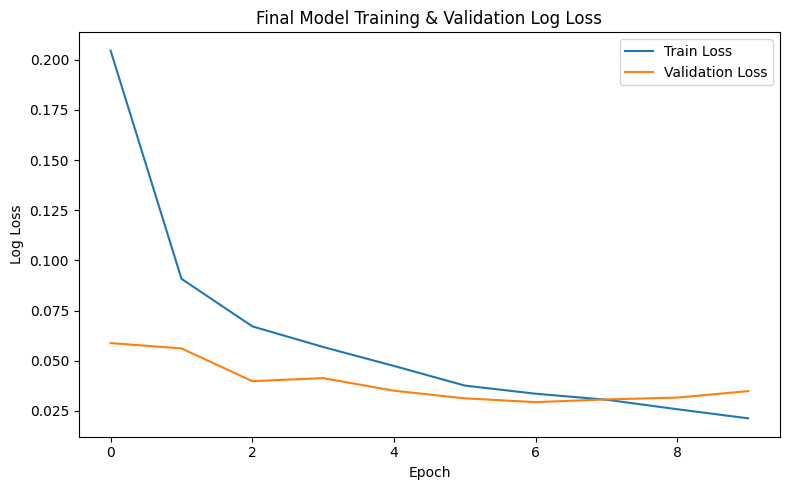

In [39]:
train_loss = final_history.get("train_loss", [])
val_loss = final_history.get("val_loss", [])

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Final Model Training & Validation Log Loss")
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

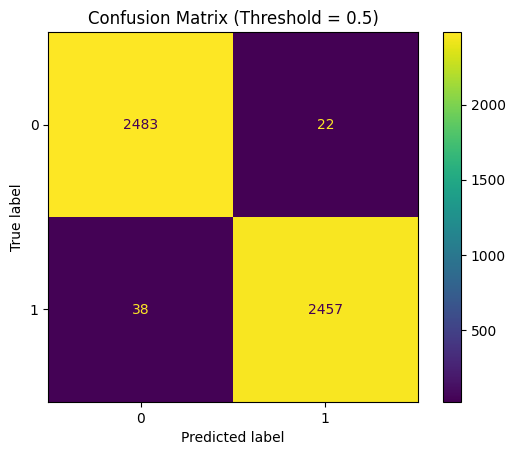

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on validation set
all_labels = []
all_probs = []

best_eff_model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        logits = best_eff_model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        
        all_probs.extend(probs.flatten())
        all_labels.extend(y.cpu().numpy().flatten())

# Convert probabilities to binary predictions
threshold = 0.5
preds = (np.array(all_probs) > threshold).astype(int)

# Create confusion matrix
cm = confusion_matrix(all_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 6))
disp.plot(values_format='d')
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()


<h2>Submit to Competition</h2>

In [40]:
class TestCatsDogsDataset(Dataset):
    def __init__(self, directory, filenames, transform=None):
        self.directory = directory
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.directory, filename)
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, filename


In [34]:
test_dir = "./test"
test_filenames = sorted(os.listdir(test_dir))

test_dataset = TestCatsDogsDataset(
    directory=test_dir,
    filenames=test_filenames,
    transform=val_transform   # SAME resize + normalize as validation
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [35]:
def predict_test(model, test_loader, device):
    model.eval()
    predictions = {}

    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()

            for fname, prob in zip(filenames, probs):
                # Extract the numeric Id from file name, e.g., "1234.jpg" → 1234
                img_id = int(fname.split('.')[0])
                predictions[img_id] = prob

    return predictions
    
test_predictions = predict_test(best_eff_model, test_loader, device)

In [36]:
submission = (
    pd.DataFrame.from_dict(test_predictions, orient="index", columns=["label"])
    .reset_index()
    .rename(columns={"index": "id"})
    .sort_values("id")
)

submission.to_csv("submission.csv", index=False)
submission.head()

,id,label
0,1,9.999875e-01
3612,2,9.999902e-01
4723,3,9.999664e-01
5834,4,9.999985e-01
6945,5,7.497555e-09


<h1>Conclusion</h1>

In this project, I explored image classification on the classic Dogs vs Cats dataset using three deep learning models: a custom CNN, ResNet18, and EfficientNet-B0. Through careful EDA, data preprocessing, augmentation, and hyperparameter tuning, all models achieved reasonable performance. Among them, EfficientNet-B0 achieved the best results, and my best submission reached a log loss of 0.07456. 

Although various optimization strategies were applied to improve model performance. While these optimizations helped slightly refine the models’ performance, the improvements were modest rather than dramatic.

<h2>What Didn't Work</h2>
Fine-tuning the custom CNN did not lead to significant improvements. Despite extensive hyperparameter tuning, its validation log loss remained high, and its performance was far worse than the pretrained transfer learning models.

<h2>Key Takeaways</h2>
This experiment confirms that transfer learning with pretrained models, combined with proper data preparation and hyperparameter tuning, can significantly improve performance on visual recognition tasks.

<h2>Future Consideration</h2>
Future Improvements: Further gains could be achieved by experimenting with larger EfficientNet variants, more advanced data augmentation techniques, learning rate schedulers, or ensemble methods combining multiple models for improved robustness.

<h1>Reference</h1>

Dogs vs. Cats Redux: Will Cukierski. Dogs vs. Cats Redux: Kernels Edition. https://kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition, 2016. Kaggle.

ResNet18: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

Efficientnet_b0: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html


<h1>Github</h1>
https://github.com/meng-shi/dogs_and_cat_deeplearning


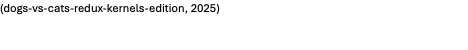
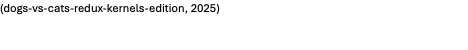
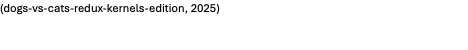
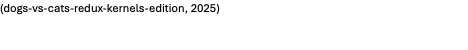